# Tutorial

In [1]:
%pip install -U dataclocklib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 18.6 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 2.2.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [1]:
import calendar
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
from dataclocklib.charts import dataclock
from matplotlib import rcParams
from matplotlib.ticker import MaxNLocator

In [2]:
data = pd.read_parquet(
    "https://raw.githubusercontent.com/andyrids/dataclocklib/main/tests/data/traffic_data.parquet.gzip"
)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 876446 entries, 904156 to 1780652
Data columns (total 13 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Date_Time                      876446 non-null  datetime64[ns]
 1   Latitude                       876419 non-null  float64       
 2   Longitude                      876419 non-null  float64       
 3   Number_of_Casualties           876446 non-null  int32         
 4   Number_of_Vehicles             876446 non-null  int32         
 5   Accident_Severity              876446 non-null  int16         
 6   Accident_Severity_Label        876446 non-null  string        
 7   Light_Conditions               876446 non-null  int16         
 8   Light_Conditions_Label         830993 non-null  string        
 9   Road_Surface_Conditions        876446 non-null  int16         
 10  Road_Surface_Conditions_Label  875033 non-null  string        
 11 

In [3]:
dow_labels = tuple(calendar.day_name)

summary_data = (
    data
    .set_index("Date_Time")
    .filter(["Number_of_Casualties"])
    .resample("1h")
    .agg(count=pd.NamedAgg(column="Number_of_Casualties", aggfunc="count"))
    .reset_index()
    .assign(day_of_week=lambda x: x["Date_Time"].dt.day_of_week)
    .assign(hour=lambda x: x["Date_Time"].dt.hour)
    .groupby(["day_of_week", "hour"])
    .agg(sum=pd.NamedAgg(column="count", aggfunc="sum"))
    .reset_index(level=1)
)

summary_data

,hour,sum
day_of_week,,
0,0,1280
0,1,823
0,2,565
0,3,474
0,4,452
...,...,...
6,19,4667
6,20,3874
6,21,3113


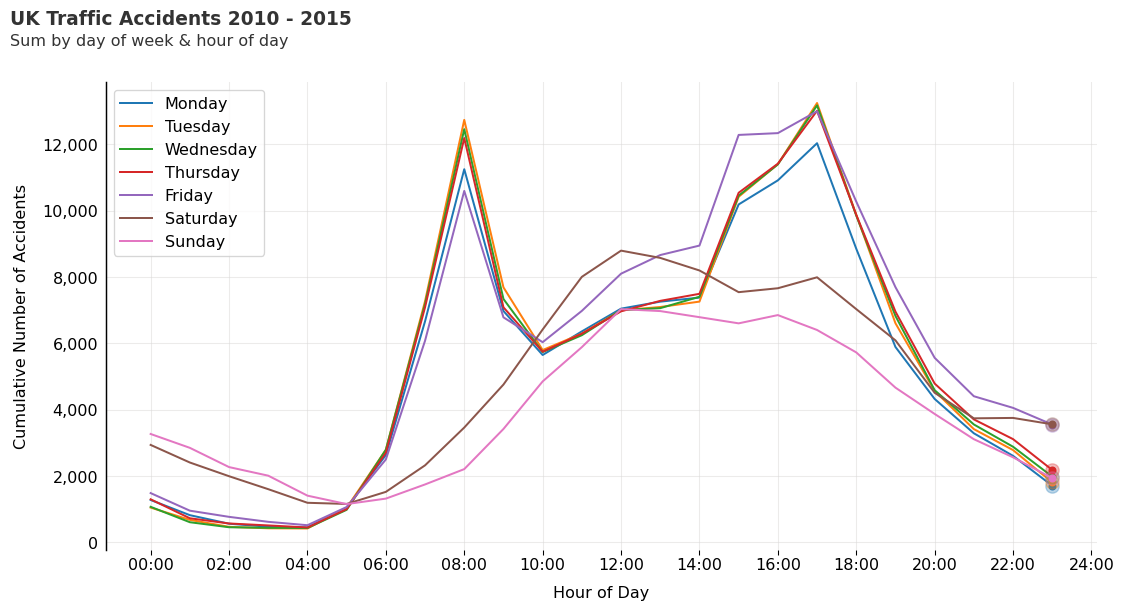

In [141]:
rcParams["font.family"] = "DejaVu Sans"

# create figure with polar projection
fig, ax = plt.subplots(figsize=(13.33, 7.5), dpi=96)

# adjust subplots for custom title, subtitle and source text
plt.subplots_adjust(
    left=None, bottom=0.2, right=None, top=0.85, wspace=None, hspace=None
)

# set white figure background
fig.patch.set_facecolor("w")

# Create the grid
ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)

ax.spines[["top", "right", "bottom"]].set_visible(False)
ax.spines['left'].set_linewidth(1.1)

ax.xaxis.set_label_position("bottom")
ax.xaxis.set_tick_params(
    pad=2, labelbottom=True, bottom=True, labelsize=12, labelrotation=0
)
ax.xaxis.set_major_formatter(lambda s, i : f"{int(s):02d}:00")
ax.xaxis.set_major_locator(MaxNLocator(23, integer=True))
ax.set_xlabel("Hour of Day", fontsize=12, labelpad=10)

ax.set_ylabel("Cumulative Number of Accidents", fontsize=12, labelpad=10)
ax.yaxis.set_label_position("left")
ax.yaxis.set_major_formatter(lambda s, i : f'{s:,.0f}')
ax.yaxis.set_tick_params(
    pad=2, labeltop=False, labelbottom=True, bottom=False, labelsize=12
)

cmap = plt.get_cmap("tab10")

for i in range(7):
    line_data = summary_data.loc[i]
    line = ax.plot(
        line_data["hour"],
        line_data["sum"],
        color=cmap(i),
        label=dow_labels[i],
        zorder=2
    )

    ax.plot(
        line_data["hour"].iloc[-1],
        line_data["sum"].iloc[-1],
        "o",
        color=cmap(i),
        markersize=10,
        alpha=0.3
    )

    ax.plot(
        line_data["hour"].iloc[-1],
        line_data["sum"].iloc[-1],
        "o",
        color=cmap(i),
        markersize=5
    )

# Add legend
ax.legend(loc="upper left", fontsize=12)

ax.text(
    x=0.05,
    y=.93,
    s="UK Traffic Accidents 2010 - 2015",
    transform=fig.transFigure,
    ha="left",
    fontsize=14,
    weight="bold",
    alpha=.8
)

ax.text(
    x=0.05,
    y=.90,
    s="Sum by day of week & hour of day",
    transform=fig.transFigure,
    ha="left",
    fontsize=12,
    alpha=.8
)

plt.show()

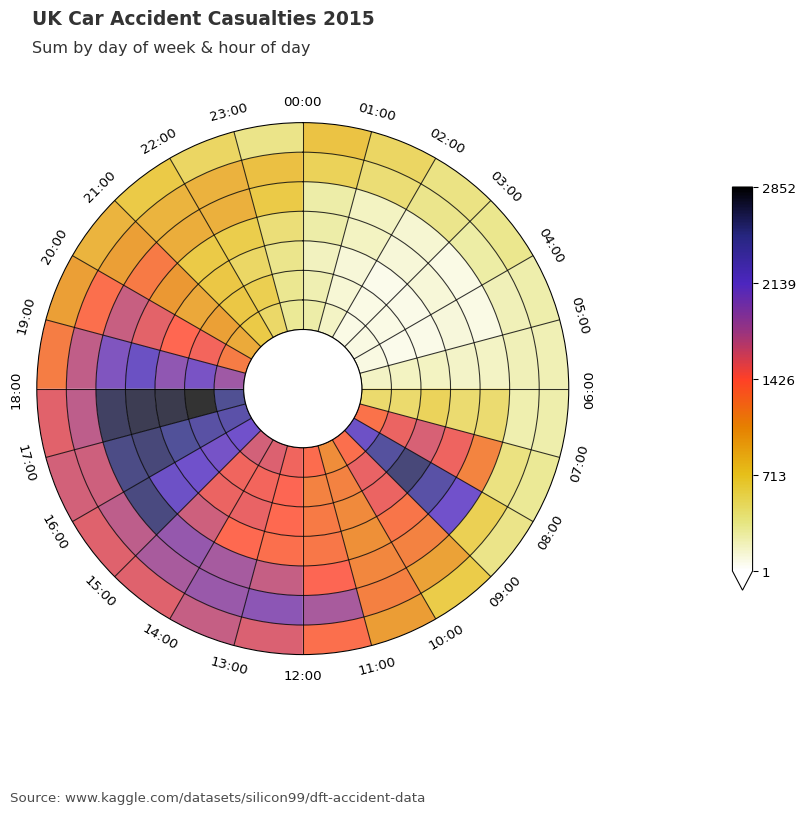

In [113]:
graph_data, fig, ax = dataclock(
      data=data.query("Date_Time.dt.year.ge(2015)"),
      date_column="Date_Time",
      agg_column="Number_of_Casualties",
      agg="sum",
      mode="DOW_HOUR",
      cmap_name="CMRmap_r",
      chart_title="UK Car Accident Casualties 2015",
      chart_subtitle=None,
      chart_source="www.kaggle.com/datasets/silicon99/dft-accident-data"
   )

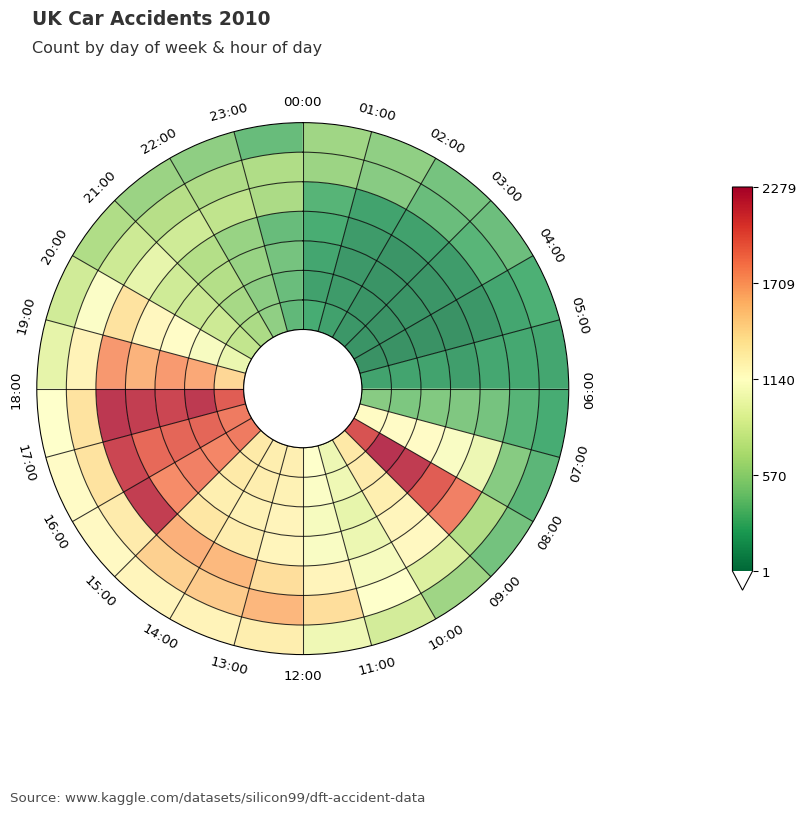

In [11]:
graph_data, fig, ax = dataclock(
    data=data.query("Date_Time.dt.year.eq(2010)"),
    date_column="Date_Time",
    agg_column=None,
    agg="count",
    mode="DOW_HOUR",
    cmap_name="RdYlGn_r",
    chart_title="UK Car Accidents 2010",
    chart_subtitle=None,
    chart_source="www.kaggle.com/datasets/silicon99/dft-accident-data"
)

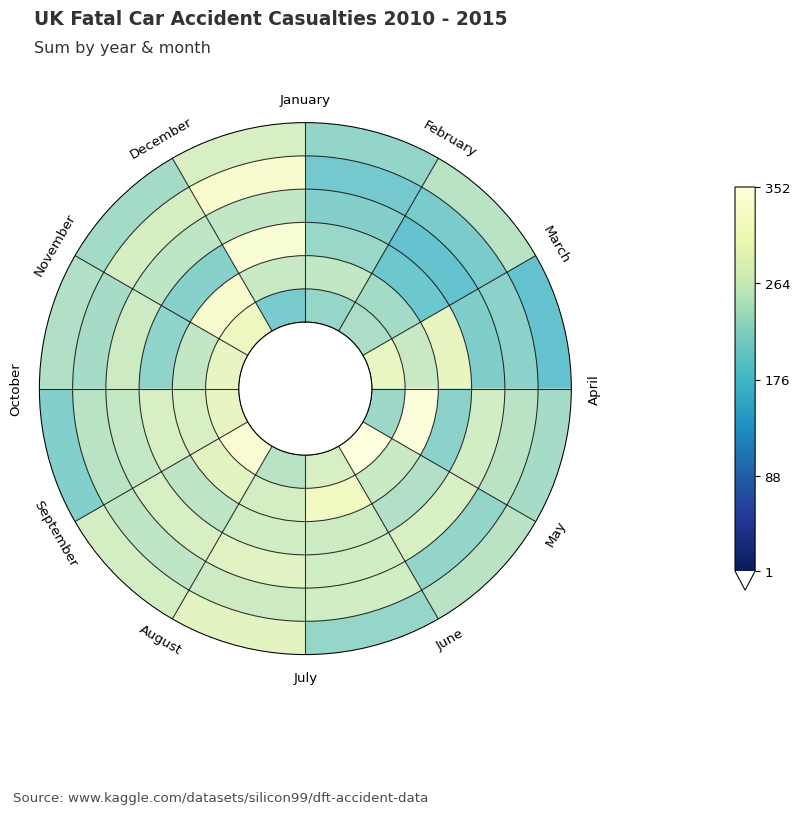

In [12]:
datetime_start = "Date_Time.ge('2010-01-1')"
datetime_stop = "Date_Time.le('2015-12-31')"
severity = "Accident_Severity.eq(1)"

graph_data, fig, ax = dataclock(
    data=data.query(f"{datetime_start} & {datetime_stop} & {severity}"),
    date_column="Date_Time",
    agg_column="Number_of_Casualties",
    agg="sum",
    mode="YEAR_MONTH",
    cmap_name="YlGnBu_r",
    chart_title="UK Fatal Car Accident Casualties 2010 - 2015",
    chart_subtitle=None,
    chart_source="www.kaggle.com/datasets/silicon99/dft-accident-data"
)